# Conditional Logic Demonstration Notebook

## Aims of Notebook

- Read accumulated I and Q data from a readout buffer and conditionally trigger a different pulse if I exceeds some threshold.

## To Do

- Remove AveragerProgram
- See if time between readout and second pulse may be reduced

In [1]:
# Import libraries
%load_ext autoreload
%autoreload 2

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Board libraries
from qick import *
import Pyro4

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "172.24.106.21" # <-- SET IP ADDRESS
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)


QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by o

In [24]:
class ConditionalPulse(AveragerProgram):
    def __init__(self,soccfg,cfg):
        super().__init__(soccfg,cfg)

    def initialize(self):
        freq_mhz = 200
        freq = self.freq2reg(freq_mhz, gen_ch=1, ro_ch=1)

        length = 0.05

        for ch in range(2):
            self.declare_gen(ch=ch, nqz=1)
  
        gen_length = self.us2cycles(length, gen_ch=1)
        phase_deg = 276.65
        phase = soccfg.deg2reg(phase_deg, gen_ch=0)
        for ch in range(2):
            self.set_pulse_registers(ch=ch, freq=freq, style="const", phase=phase, 
                                 gain=20000, length=gen_length)


        ro_phase = self.deg2reg(262.04402341090645, ro_ch=1, gen_ch=None)
        # print(ro_phase)
        ro_length = self.us2cycles(length-0.001, ro_ch=1)
        self.declare_readout(ch=1, freq=freq_mhz, length=180, phase=ro_phase ,gen_ch=1)

        # self.synci(100) 
    
    def body(self):
        self.pulse(ch=1, t=0) 
        self.pulse(ch=0, t=0) 
        self.trigger(adcs=[1], pins=[0], adc_trig_offset=0) 
        # self.trigger(adcs=[1]) 
        print("Timestamps")
        print(self.get_max_timestamp(gens=False, ros=True))
        print(self.get_max_timestamp(gens=True, ros=False))
        self.pulse(ch=0, t=self.get_max_timestamp(gens=False, ros=True))
        
        self.wait_all(80) #pause execution of commands until the end of the readout window, plus N cycles
        self.sync_all()
        self.trigger(pins=[0])
        self.pulse(ch=0)
        # self.sync_all() #increment the time of subsequent pulse and trigger commands to the end of the last pulse, plus 500

        self.read(1, 0, "lower", 1) # read input 0's accumulated I into page 0, reg 1 (gen_ch, p, "upper"/"lower", r)
        # self.read(1, 0, "upper", 2) # read input 0's accumulated Q into page 0, reg 2
        self.memwi(0, 1, 123)
        # self.memwi(0, 2, 124)
        
        # self.condj(0, 1, '<', 0, "JUMP_LOC")
        # self.pulse(ch=0)
        # self.label("JUMP_LOC")

        # the extra time in wait_all needs to be at least ~30, otherwise you will read a stale value corresponding to the previous readout
        # try a smaller value and you will see what I mean
        # the extra time here is optional? do whatever you need to get the timeline you want
        # if you are only running one rep and there are no more triggers or pulses, you don't even need a sync

        # it's important to only use registers that are not used elsewhere
        # some registers are used for averagerprogram/raveragerprogram counters, and each generator uses some registers for pulse parameters
        # we don't currently have a nice way to check which registers are unused (this is issue #19)
        # for now: page 0 registers 1-12 are not used

In [25]:
config={"reps":1,
        # "soft_avgs":10,
        }

prog = ConditionalPulse(soccfg, config)
# soc.reset_gens() # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False)

results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in range(123,125)]
print("I and Q values read from tproc input:", results)
print("sum of I and Q in decimated buffer:", [sum(iq) for iq in iq_list[0]])
# i = np.average(iq[0])
# q = np.average(iq[1])
# print(np.angle(i+1j*q, deg=True)%360)

# # Plot results.
# plt.figure(1)
# iq = iq_list[0]
# plt.plot(iq[0], label="I value, ADC %d"%(1))
# plt.plot(iq[1], label="Q value, ADC %d"%(1))
# plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(1))

# # print(sum(iq[0]), sum(iq[1]))

# plt.ylabel("a.u.")
# plt.xlabel("Clock ticks")
# plt.legend();
# # plt.savefig("images/Send_recieve_pulse_const.pdf", dpi=350)

# print(prog)

Timestamps
133.33333333333331
20.666666666666668
I and Q values read from tproc input: [23, 0]
sum of I and Q in decimated buffer: [23.0, 27.0]


In [3495]:
prog.cycles2us(220) # Number of cycles between ro beginning and non-junk data
prog.cycles2us(133)
prog.cycles2us(125, ro_ch=1)

0.22605613425925924

```
waiti 0, 35;
```
```
regwi 0, $16, 32768;                    //out = 0b1000000000000000
seti 7, 0, $16, 169;                    //ch =0 out = $16 @t = 0
seti 7, 0, $0, 179;                     //ch =0 out = 0 @t = 0
waiti 0, 224;
```

In [2887]:
print(prog.cycles2us(169))
print(prog.cycles2us(179))
print(prog.cycles2us(224))
print(prog.cycles2us(169-78))

0.41259765625
0.43701171875
0.546875
0.22216796875


In [3232]:
class ConditionalPulse(AveragerProgram):
    def __init__(self,soccfg,cfg):
        super().__init__(soccfg,cfg)

    def initialize(self):
        freq_mhz = 200
        freq = self.freq2reg(freq_mhz, gen_ch=1, ro_ch=1)

        length = 0.05
        gen_length = self.us2cycles(length, gen_ch=1)
        ro_length = self.us2cycles(length-0.001, ro_ch=1)

        # for ch in range(1):
        #     self.declare_gen(ch=ch, nqz=1)
  
        # for ch in range(1):
        #     self.set_pulse_registers(ch=ch, freq=freq, style="const", phase=0, 
        #                          gain=20000, length=gen_length)


        self.declare_readout(ch=1, freq=freq_mhz, length=ro_length,gen_ch=1)

        self.synci(200) 
    
    def body(self):
        # self.pulse(ch=1, t=100) 
        # self.pulse(ch=0, t=0) 
        # self.trigger(pins=[0], t=35, width=self.us2cycles(0.05))
        self.trigger(adcs=[1], t=0, adc_trig_offset=132) 
        
        # self.wait_all(35) #pause execution of commands until the end of the readout window, plus N cycles
        # self.trigger(pins=[0])
        # self.pulse(ch=0)
        # self.sync_all() #increment the time of subsequent pulse and trigger commands to the end of the last pulse, plus 500

        # self.read(1, 0, "lower", 1) # read input 0's accumulated I into page 0, reg 1 (gen_ch, p, "upper"/"lower", r)
        # self.read(1, 0, "upper", 2) # read input 0's accumulated Q into page 0, reg 2
        # self.memwi(0, 1, 123)
        # self.memwi(0, 2, 124)
        
        # self.condj(0, 1, '<', 0, "JUMP_LOC")
        # self.label("JUMP_LOC")

config={"reps":1}
prog =ConditionalPulse(soccfg, config)
print(prog)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False)


// Program

        synci 200;
        regwi 0, $15, 0;
        regwi 0, $14, 0;
LOOP_J: regwi 0, $16, 32768;                    //out = 0b1000000000000000
        seti 7, 0, $16, 140;                    //ch =0 out = $16 @t = 0
        seti 7, 0, $0, 150;                     //ch =0 out = 0 @t = 0
        mathi 0, $15, $15 + 1;
        memwi 0, $15, 1;
        loopnz 0, $14, @LOOP_J;
        end ;


read = 2 cycles
memwi = 2 cycles
condj = 4 cycles

wait_all = 124.8 ns

// Program

LOOP_J: regwi 0, $16, 32768;                    //out = 0b1000000000000000
        seti 7, 0, $16, 132;                    //ch =0 out = $16 @t = 0
        seti 7, 0, $0, 142;                     //ch =0 out = 0 @t = 0

In [3208]:
print(prog.cycles2us(1)*1e3*35)

85.44921875


In [2375]:
iq_list = prog.acquire(soc, load_pulses=True, progress=True)

results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in range(123,125)]
print("I and Q values read from tproc input:", results)
print("I and Q values in accumulated buffer:", [iq*config['readout_length'] for iq in iq_list])


  0%|          | 0/1 [00:00<?, ?it/s]

I and Q values read from tproc input: [-14, 0]


KeyError: 'readout_length'

## BELOW CELL DOES NOT WORK

In [ ]:
prog = QickProgram(soccfg) # Create program object

prog.declare_gen(ch=1, nqz=1)
prog.set_pulse_registers(ch=1, gain=10000, freq=prog.freq2reg(100), phase=0, style="const", length=500)
prog.declare_readout(ch=1,length=100,freq=100,gen_ch=1)
# prog.pulse(ch=1, t=0)
prog.regwi(0,3,1)
prog.trigger(adcs=[1], t=400, adc_trig_offset=0, rp=0, r_out=3)
prog.waiti(0,1000)

# prog.read(1,0,"lower",3)
prog.regwi(0,2,1)
# prog.condj(0,2,'>',3,'after_reset')
prog.trigger(pins=[0], t=0, width=10)

prog.memwi(0, 3, 123)
# prog.label('after_reset')
prog.wait_all()
prog.end()

prog.config_all(soc) # Load assembly to board
soc.tproc.start() # Run program

time.sleep(0.1)

data = soc.tproc.single_read(addr=123)
print(data)

# print(prog)

32768


In [3562]:
prog = QickProgram(soccfg)
freq_mhz = 200
freq = prog.freq2reg(freq_mhz, gen_ch=1, ro_ch=1)
length = 0.05
gain=10000

for ch in range(2):
    prog.declare_gen(ch=ch, nqz=1)

gen_length = prog.us2cycles(length, gen_ch=1)
for ch in range(2):
    prog.set_pulse_registers(ch=ch, freq=freq, style="const", phase=0, 
                            gain=gain, length=gen_length)

ro_length = prog.us2cycles(length, ro_ch=1)
prog.declare_readout(ch=1, freq=freq_mhz, length=ro_length, gen_ch=1)

prog.synci(100) 
    
prog.trigger(adcs=[1], adc_trig_offset=132) 
prog.pulse(ch=1) 
prog.pulse(ch=0) 

prog.wait_all(35) #pause execution of commands until the end of the readout window, plus N cycles
# self.waiti(1000, 0)
# self.sync_all() #increment the time of subsequent pulse and trigger commands to the end of the last pulse, plus 500

prog.read(1, 0, "lower", 1) # read input 0's accumulated I into page 0, reg 1 (gen_ch, p, "upper"/"lower", r)
prog.read(1, 0, "upper", 2) # read input 0's accumulated Q into page 0, reg 2
prog.memwi(0, 1, 123)
prog.memwi(0, 2, 124)

# prog.regwi(0, 1, 5000)

prog.condj(0, 1, '>', 0, "JUMP_LOC")
prog.pulse(ch=0)
prog.label("JUMP_LOC")
prog.end()

prog.config_all(soc) # Load the assembly onto the board

# prog.compile()
# soc.start_src("external")
# prog.load_pulses(soc)
# prog.config_gens(soc)
# prog.config_readouts(soc)
# soc.load_bin_program(prog.binprog)

soc.tproc.start() # Start tproc program execution

results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in range(123,125)]
print("I and Q values read from tproc input:", results)

I and Q values read from tproc input: [-362, -2920]


# Try again with external trigger

In [ ]:
readings = []
offsets = []
for offset in range(1000):
    offsets.append(offset)
    gain = 30000

    prog = QickProgram(soccfg)
    prog.declare_gen(ch=0)

    freq_mhz = 200
    gen_freq = prog.freq2reg(freq_mhz, gen_ch=1, ro_ch=1)

    gen_length = prog.us2cycles(0.005, gen_ch=1)
    ro_length = prog.us2cycles(0.001, ro_ch=1)

    prog.set_pulse_registers(ch=0, style="const", length=gen_length, freq=gen_freq, phase=0, gain=gain)
    prog.declare_readout(ch=1, freq=freq_mhz, length=1, gen_ch=1)

    prog.synci(200)

    prog.trigger(pins=[0], t=150)
    prog.trigger(adcs=[1], t=100, adc_trig_offset=offset) 
    prog.pulse(ch=0, t=100)

    prog.wait_all(500) #pause execution of commands until the end of the readout window, plus N cycles
    prog.read(1, 0, "lower", 1) # read input 0's accumulated I into page 0, reg 1 (gen_ch, p, "upper"/"lower", r)
    prog.read(1, 0, "upper", 2) # read input 0's accumulated Q into page 0, reg 2
    prog.memwi(0, 1, 123)
    prog.memwi(0, 2, 124)
    prog.end()

    prog.compile()
    # soc.start_src("external")
    soc.start_src("internal")
    prog.load_pulses(soc)
    prog.config_gens(soc)
    soc.load_bin_program(prog.binprog)

    soc.tproc.start()

    results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in [123, 124]]
    result = np.absolute(results[0] + 1j*results[1])
    readings.append(result)
    # print("I, Q:", result)

max_item = max(readings)
max_index = readings.index(max_item)
optimal_offset = offsets[max_index]
print(readings)
print(optimal_offset)

[7166.833052332111, 6674.39742598536, 7076.313870935913, 6891.471831183815, 7014.913042939306, 7024.935302193181, 6773.750881158828, 6855.189712910942, 6934.527236949899, 7100.863679863176, 6765.306571028396, 6981.8216820540465, 6925.665383196044, 6883.865919670429, 6825.822221534927, 6901.306687867161, 6928.161949608279, 6945.181927062818, 7059.167797977322, 6953.888840066398, 6796.6083453440215, 6873.0398660272585, 6867.555678696752, 6938.088785825676, 7027.540465909819, 6931.356721450715, 6974.213432352067, 7007.489207983128, 6807.572327930126, 6875.254177119563, 6876.842371321303, 6805.19801328367, 6980.517172817498, 6889.407811996616, 7071.219484643367, 6856.178308649798, 7013.544182508584, 6863.586963097357, 6906.017738175888, 7097.497939414988, 6811.50122953817, 6850.566764874276, 7129.898877263267, 7177.857758412324, 6894.461835415437, 6930.925840030321, 7114.174020924706, 6933.300873321451, 7346.656450386121, 7214.416954959008, 7217.168004141236, 6822.560956121975, 7081.142986

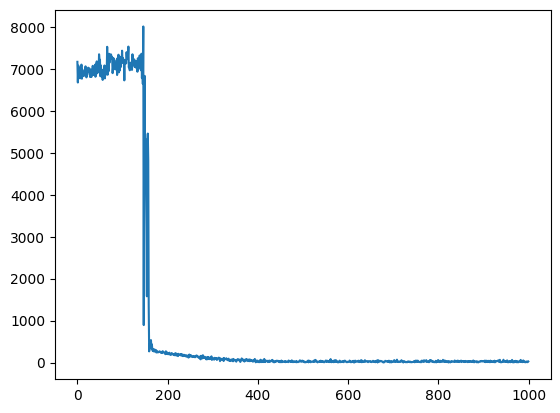

In [ ]:
plt.plot(readings)

In [ ]:
readings = []
gains = [False, True]
for wait_time in range(200):
    correct = True
    readings.append([])
    for gain in gains:
        prog = QickProgram(soccfg)
        prog.declare_gen(ch=0)
        prog.declare_gen(ch=1)

        freq_mhz = 200
        gen_freq = prog.freq2reg(freq_mhz, gen_ch=1, ro_ch=1)
        gen_length = prog.us2cycles(0.005, gen_ch=1)
        ro_length = prog.us2cycles(0.001, ro_ch=1)

        for ch in range(2):
            prog.set_pulse_registers(ch=ch, style="const", length=gen_length, freq=gen_freq, phase=0, gain=gain)
        prog.declare_readout(ch=1, freq=freq_mhz, length=1, gen_ch=1)

        prog.synci(30)

        prog.pulse(ch=0)
        if gain:
            prog.trigger(pins=[0])
        # prog.pulse(ch=1)
        prog.trigger(adcs=[1], adc_trig_offset=0) 

        prog.wait_all(wait_time)
        prog.read(1, 0, "lower", 1) # read input 0's accumulated I into page 0, reg 1 (gen_ch, p, "upper"/"lower", r)
        prog.read(1, 0, "upper", 2) # read input 0's accumulated Q into page 0, reg 2
        prog.memwi(0, 1, 123)
        prog.memwi(0, 2, 124)

        # prog.condj(0, 1, '<', 0, "JUMP_LOC")
        # prog.pulse(ch=0)
        # prog.label("JUMP_LOC")
        prog.end()

        prog.compile()
        # soc.start_src("external")
        soc.start_src("internal")
        prog.load_pulses(soc)
        prog.config_gens(soc)
        soc.load_bin_program(prog.binprog)

        soc.tproc.start()

        prev_result = result
        results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in [123, 124]]
        result = np.absolute(results[0] + 1j*results[1])
        readings[-1].append(result)

In [ ]:
for i in range(len(readings)):
    if readings[i][0] > readings[i][1]:
        print(i, "FAIL")
    else:
        print(i, "PASS")

0 FAIL
1 FAIL
2 FAIL
3 FAIL
4 FAIL
5 FAIL
6 FAIL
7 FAIL
8 FAIL
9 FAIL
10 FAIL
11 FAIL
12 FAIL
13 FAIL
14 FAIL
15 FAIL
16 FAIL
17 FAIL
18 FAIL
19 FAIL
20 FAIL
21 FAIL
22 FAIL
23 FAIL
24 FAIL
25 FAIL
26 FAIL
27 FAIL
28 FAIL
29 FAIL
30 FAIL
31 FAIL
32 FAIL
33 FAIL
34 FAIL
35 FAIL
36 FAIL
37 FAIL
38 FAIL
39 FAIL
40 FAIL
41 FAIL
42 FAIL
43 FAIL
44 FAIL
45 FAIL
46 FAIL
47 FAIL
48 FAIL
49 FAIL
50 FAIL
51 FAIL
52 FAIL
53 FAIL
54 FAIL
55 FAIL
56 FAIL
57 FAIL
58 FAIL
59 FAIL
60 FAIL
61 FAIL
62 FAIL
63 FAIL
64 FAIL
65 FAIL
66 FAIL
67 FAIL
68 FAIL
69 FAIL
70 FAIL
71 FAIL
72 FAIL
73 FAIL
74 FAIL
75 FAIL
76 FAIL
77 FAIL
78 FAIL
79 FAIL
80 FAIL
81 FAIL
82 FAIL
83 FAIL
84 FAIL
85 FAIL
86 FAIL
87 FAIL
88 FAIL
89 FAIL
90 FAIL
91 FAIL
92 FAIL
93 FAIL
94 FAIL
95 FAIL
96 FAIL
97 FAIL
98 FAIL
99 FAIL
100 FAIL
101 FAIL
102 FAIL
103 FAIL
104 FAIL
105 FAIL
106 FAIL
107 FAIL
108 FAIL
109 FAIL
110 FAIL
111 FAIL
112 FAIL
113 FAIL
114 FAIL
115 FAIL
116 FAIL
117 FAIL
118 FAIL
119 FAIL
120 FAIL
121 FAIL
122 FAIL
123

In [ ]:
prog = QickProgram(soccfg)
prog.declare_gen(ch=0)
prog.declare_gen(ch=1)

freq_mhz = 200
gen_freq = prog.freq2reg(freq_mhz, gen_ch=1, ro_ch=1)
gen_length = prog.us2cycles(0.005, gen_ch=1)
ro_length = prog.us2cycles(0.001, ro_ch=1)

for ch in range(2):
    prog.set_pulse_registers(ch=ch, style="const", length=gen_length, freq=gen_freq, phase=0, gain=gain)
prog.declare_readout(ch=1, freq=freq_mhz, length=ro_length, gen_ch=1)

prog.synci(30)

prog.pulse(ch=0)
# prog.pulse(ch=1)
prog.trigger(pins=[0])
prog.trigger(adcs=[1], adc_trig_offset=5) 

prog.wait_all(165)
prog.read(1, 0, "lower", 1) # read input 0's accumulated I into page 0, reg 1 (gen_ch, p, "upper"/"lower", r)
prog.read(1, 0, "upper", 2) # read input 0's accumulated Q into page 0, reg 2
prog.memwi(0, 1, 123)
prog.memwi(0, 2, 124)

prog.condj(0, 1, '<', 0, "JUMP_LOC")
# prog.pulse(ch=0)
prog.trigger(pins=[0])
prog.label("JUMP_LOC")
prog.end()

prog.compile()
# soc.start_src("external")
soc.start_src("internal")
prog.load_pulses(soc)
prog.config_gens(soc)
soc.load_bin_program(prog.binprog)

soc.tproc.start()

prev_result = result
results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in [123, 124]]
result = np.absolute(results[0] + 1j*results[1])
print("I, Q:", result)

I, Q: 7056.4955891717245


# Try again with no acquire

In [ ]:
import random

In [ ]:
readings = []
offsets = []
for offset in range(200):
    offsets.append(offset)
    prev_gain = gain
    gain = 30000

    prog = QickProgram(soccfg)
    prog.declare_gen(ch=0)
    prog.declare_gen(ch=1)

    freq_mhz = 200
    gen_freq = prog.freq2reg(freq_mhz, gen_ch=1, ro_ch=1)

    gen_length = prog.us2cycles(0.1, gen_ch=1)
    ro_length = prog.us2cycles(0.1, ro_ch=1)

    for ch in range(2):
        prog.set_pulse_registers(ch=ch, style="const", length=gen_length, freq=gen_freq, phase=0, gain=gain)
    prog.declare_readout(ch=1, freq=freq_mhz, length=ro_length, gen_ch=1)

    prog.synci(200)

    prog.trigger(adcs=[1], adc_trig_offset=offset) 
    prog.pulse(ch=0)
    prog.pulse(ch=1)

    prog.wait_all(500) #pause execution of commands until the end of the readout window, plus N cycles
    prog.read(1, 0, "lower", 1) # read input 0's accumulated I into page 0, reg 1 (gen_ch, p, "upper"/"lower", r)
    prog.read(1, 0, "upper", 2) # read input 0's accumulated Q into page 0, reg 2
    prog.memwi(0, 1, 123)
    prog.memwi(0, 2, 124)
    prog.end()

    prog.compile()
    # soc.start_src("external")
    soc.start_src("internal")
    prog.load_pulses(soc)
    prog.config_gens(soc)
    soc.load_bin_program(prog.binprog)

    soc.tproc.start()

    prev_result = result
    results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in [123, 124]]
    result = np.absolute(results[0] + 1j*results[1])
    readings.append(result)
    # print("I, Q:", result)

max_item = max(readings)
max_index = readings.index(max_item)
optimal_offset = offsets[max_index]
print(readings)
print(optimal_offset)

[838.6495096284264, 990.3095475658104, 1714.7851177334144, 1844.0661593337697, 2496.6076984580495, 2638.0001895375217, 3279.9146330354392, 3767.3567656912983, 4320.783493765916, 4689.37618452604, 5107.502422906914, 5390.154450477277, 5936.243930298013, 6491.771098860464, 7141.049362663725, 7152.527175761026, 7967.478961377934, 8056.870670427818, 8790.907404813226, 9113.861969549462, 9422.545144492544, 9884.70419385426, 10130.741433873436, 10980.84377450112, 10976.732209542146, 11816.58804393214, 11958.827074592224, 12617.43337608723, 12983.960297228268, 13462.270573718239, 14121.760796727864, 14167.945581487811, 14791.765885113244, 15177.356093865625, 15637.770301420851, 16269.03970737056, 16650.82388352, 17124.016176119432, 17323.53018296213, 17926.919004670042, 17837.416853345105, 17928.548686382845, 17844.02244450505, 17769.334540156535, 17981.979006772308, 17848.52646578983, 17857.850178562927, 18037.151354911894, 17899.45524310726, 17882.860453518057, 17861.953420608843, 17765.499

In [ ]:
print(readings[38])
print(readings[50])

17323.53018296213
17861.953420608843


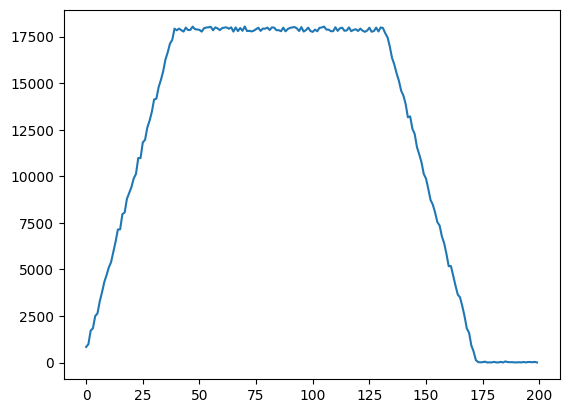

In [ ]:
plt.plot(readings)

In [ ]:
readings = []
gains = [1000, 30000]
for wait_time in range(200):
    correct = True
    readings.append([])
    for gain in gains:
        prog = QickProgram(soccfg)
        prog.declare_gen(ch=0)
        prog.declare_gen(ch=1)

        freq_mhz = 200
        gen_freq = prog.freq2reg(freq_mhz, gen_ch=1, ro_ch=1)
        gen_length = prog.us2cycles(0.1, gen_ch=1)
        ro_length = prog.us2cycles(0.1, ro_ch=1)

        for ch in range(2):
            prog.set_pulse_registers(ch=ch, style="const", length=gen_length, freq=gen_freq, phase=0, gain=gain)
        prog.declare_readout(ch=1, freq=freq_mhz, length=ro_length, gen_ch=1)

        prog.synci(200)

        prog.trigger(adcs=[1], adc_trig_offset=40) 
        prog.pulse(ch=0)
        prog.pulse(ch=1)

        prog.wait_all(wait_time)
        prog.read(1, 0, "lower", 1) # read input 0's accumulated I into page 0, reg 1 (gen_ch, p, "upper"/"lower", r)
        prog.read(1, 0, "upper", 2) # read input 0's accumulated Q into page 0, reg 2
        prog.memwi(0, 1, 123)
        prog.memwi(0, 2, 124)

        # prog.condj(0, 1, '<', 0, "JUMP_LOC")
        # prog.pulse(ch=0)
        # prog.label("JUMP_LOC")
        prog.end()

        prog.compile()
        # soc.start_src("external")
        soc.start_src("internal")
        prog.load_pulses(soc)
        prog.config_gens(soc)
        soc.load_bin_program(prog.binprog)

        soc.tproc.start()

        prev_result = result
        results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in [123, 124]]
        result = np.absolute(results[0] + 1j*results[1])
        readings[-1].append(result)

In [ ]:
for i in range(len(readings)):
    if readings[i][0] > readings[i][1]:
        print(i, "FAIL")
    else:
        print(i, "PASS")

0 FAIL
1 FAIL
2 FAIL
3 FAIL
4 FAIL
5 FAIL
6 FAIL
7 FAIL
8 FAIL
9 FAIL
10 FAIL
11 FAIL
12 FAIL
13 FAIL
14 FAIL
15 FAIL
16 FAIL
17 FAIL
18 FAIL
19 FAIL
20 FAIL
21 FAIL
22 FAIL
23 FAIL
24 FAIL
25 FAIL
26 FAIL
27 FAIL
28 FAIL
29 FAIL
30 FAIL
31 FAIL
32 FAIL
33 FAIL
34 FAIL
35 FAIL
36 FAIL
37 FAIL
38 FAIL
39 FAIL
40 FAIL
41 FAIL
42 FAIL
43 FAIL
44 FAIL
45 FAIL
46 FAIL
47 FAIL
48 FAIL
49 FAIL
50 FAIL
51 FAIL
52 FAIL
53 FAIL
54 FAIL
55 FAIL
56 FAIL
57 FAIL
58 FAIL
59 FAIL
60 FAIL
61 FAIL
62 FAIL
63 FAIL
64 FAIL
65 FAIL
66 FAIL
67 FAIL
68 FAIL
69 FAIL
70 FAIL
71 FAIL
72 FAIL
73 FAIL
74 FAIL
75 FAIL
76 FAIL
77 FAIL
78 FAIL
79 FAIL
80 FAIL
81 FAIL
82 FAIL
83 FAIL
84 FAIL
85 FAIL
86 FAIL
87 FAIL
88 FAIL
89 FAIL
90 FAIL
91 FAIL
92 FAIL
93 FAIL
94 FAIL
95 FAIL
96 FAIL
97 FAIL
98 FAIL
99 FAIL
100 FAIL
101 FAIL
102 FAIL
103 FAIL
104 FAIL
105 FAIL
106 FAIL
107 FAIL
108 FAIL
109 FAIL
110 FAIL
111 FAIL
112 FAIL
113 FAIL
114 FAIL
115 FAIL
116 FAIL
117 FAIL
118 FAIL
119 FAIL
120 FAIL
121 FAIL
122 FAIL
123

In [ ]:
prog = QickProgram(soccfg)

freq = 200
gen_freq = prog.freq2reg(freq_mhz, gen_ch=1, ro_ch=1)

length = 0.1
gen_length = prog.us2cycles(length, gen_ch=1)
ro_length = prog.us2cycles(length, ro_ch=1)

prog.declare_readout(ch=1, freq=freq, length=ro_length, gen_ch=1)
for ch in range(2):
    prog.declare_gen(ch=ch)
    prog.set_pulse_registers(ch=ch, style="const", length=gen_length, freq=gen_freq, phase=0, gain=gain)

prog.synci(200)

prog.trigger(adcs=[1], adc_trig_offset=40) 
prog.pulse(ch=0)
prog.pulse(ch=1)

prog.wait_all(125)

prog.read(1, 0, "lower", 1)
prog.read(1, 0, "upper", 2)
prog.memwi(0, 1, 123)
prog.memwi(0, 2, 124)

prog.condj(0, 1, '<', 0, "JUMP_LOC")
prog.pulse(ch=0)
prog.label("JUMP_LOC")

prog.end()

prog.compile()
# soc.start_src("external")
soc.start_src("internal")
prog.load_pulses(soc)
prog.config_gens(soc)
soc.load_bin_program(prog.binprog)

soc.tproc.start()

prev_result = result
results = [np.int32(soc.tproc.single_read(addr=addr)) for addr in [123, 124]]
result = np.absolute(results[0] + 1j*results[1])
print("I, Q:", result)

I, Q: 17892.58731989312
